In [1]:
#run imports
import torch, time, Data, random, sys, json
import matplotlib.pyplot as plt
import torch.nn as nn
from tokenizer import Tokenizer
from model import Transformer
torch.random.manual_seed(1)

#choose device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f'Device set to {device}')

Device set to cuda:0


In [2]:
#get data
train_file='tbbt_train.txt'
test_file='tbbt_test.txt'
vocab_file = 'vocab_chars.json'

file = open(vocab_file, 'r')
vocab = json.loads(file.read())
file.close()

tokenizer = Tokenizer(vocab)

data = Data.Data(train_file, test_file, tokenizer, sample_data=True)

#sample data
x, y = data.get_random_train_sample(sample_len=128, num_samples = 1)
print(x)
print(y)
print(f'X: {x.shape}, Y: {y.shape}')
print('X: (batch size, chunk size), Y: (batch size, chunk size, num char)')

character list:
	['\n', ' ', '!', '$', '%', '&', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

tensor([[50, 33,  1, 37, 34,  1, 53, 43, 49,  1, 31, 43, 49, 42, 48,  1, 48, 36,
         33,  1, 43, 42, 33, 47,  1, 51, 36, 43,  1, 47, 36, 43, 51, 33, 32,  1,
         49, 44,  1, 29, 42, 32,  1, 40, 33, 34, 48, 11,  0,  0, 47, 36, 33, 40,
         32, 43, 42, 23,  1,  1, 37,  1, 31, 29, 42, 48,  1, 30, 46, 37, 42, 35,
          1, 48, 36, 33,  1, 42, 37, 48, 46, 43, 35, 33, 42,  1, 48, 29, 42, 39,
          1, 32, 43, 51, 42, 11,  0,  0, 40, 33, 43, 42, 29, 46, 32, 23,  1,  1,
         51, 36, 53,  1, 42, 43, 48, 28,  0,  0, 47, 36, 33, 40, 32, 43, 42, 23,
          1,  1]])
tensor([[33,  1, 37, 34,  1, 53, 43, 49,  1, 31, 43, 49, 42, 48,  1, 48, 36, 33,
          1, 43, 42, 33, 47,  1, 51, 3

In [3]:
# Create new model with hyper parameters
chunk_size = 128*4
embedding_dim = 256*2 #must be some factor of heads in attention layers

# Transforer Hyper parameters
num_attention_blocks = 16
num_heads = 8

# Regularization parameters
dropout_rate = 0.1
weight_decay = 1.0

# Training parameters
batch_size = 8
learning_rate = 0.001 #0.0001 learns fastest
train_time = 6000 # minutes
num_step = 15000

# Training
flatten_const = 100

# Create new model from hyper parameters
model = Transformer(
    len(tokenizer.vocab_list), 
    embedding_dim, chunk_size, 
    num_heads, 
    num_attention_blocks, 
    learning_rate, 
    dropout_rate
).to(device)

print(model.get_parameter_count(), 'Million Parameters')

model.optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
cost_data, cost_it, val_data=[],[], []
step=0

50.733111 Million Parameters


In [4]:
model = torch.compile(model, backend="eager", mode="reduce-overhead")

In [5]:
# load saved checkpoint
# model:Transformer = Transformer.create_from_checkpoint('Checkpoint.pth.tar', device=device).to(device)
# cost_data = model.training_state['cost_data']
# val_data = model.training_state['val_data']

In [6]:
print('Appx num steps before overfit:', int(len(data._encoded_train_data)/(model.ctx_window_length+(batch_size-1))))

Appx num steps before overfit: 5749


In [7]:
print(data.train_text.count('</ep'))

184


In [10]:
# Train Model
model.train()
start=time.time()

while(time.time()-start<60*train_time):
    step+=1
    x_train, y_train= data.get_random_train_sample(model.ctx_window_length, batch_size)
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    # Forward pass
    outputs, loss = model(x_train, y_train)

    # Backward and optimize
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()

    cost_it.append(loss.item())


    #flatten graph data
    if (step + 1) % flatten_const == 0:
        cost_data.append(torch.tensor(cost_it).mean().item())
        cost_it=[]

    #print update
    if (step + 1) % flatten_const == 0:
        
        # Run test set
        model.eval()
        test_batch_size=64
        with torch.no_grad():
            x, y = data.get_random_test_sample(model.ctx_window_length, test_batch_size)
            x=x.to(device)
            y=y.to(device)
            outputs, val_loss = model(x, y)
            val_data.append(val_loss.item())
        model.train()
        
        # Save if new best
        if len(val_data)==1 or val_data[-1]<min(val_data[:-1]):
            model.save_checkpoint('Best_Checkpoint.pth.tar', training_state={'cost_data':cost_data, 'val_data':val_data})

        torch.cuda.empty_cache()
        print(f"Step [{step+1}], Loss: {cost_data[-1]:.4f}, Val Loss: {val_data[-1]:.4f}")

    if (step + 1) % 5000 == 0:
        model.save_checkpoint('Checkpoint.pth.tar', training_state={'cost_data':cost_data, 'val_data':val_data})
        print('Saved Checkpoint')

print(step)

torch.cuda.empty_cache()

Step [3500], Loss: 1.2828, Val Loss: 1.2294
Step [3600], Loss: 1.2819, Val Loss: 1.2136
Step [3700], Loss: 1.2875, Val Loss: 1.2043


KeyboardInterrupt: 

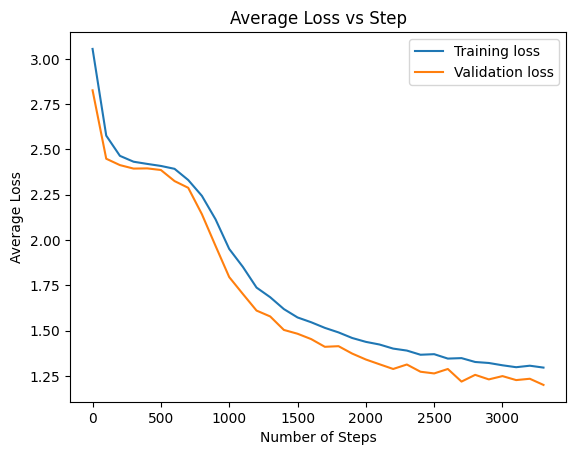

1.201185703277588


In [9]:
# Plot training data
plt.plot(torch.arange(0, len(cost_data))*flatten_const, cost_data, label='Training loss')
#plt.plot(torch.arange(800, len(cost_data))*flatten_const, cost_data[800:], label='Training loss')
plt.plot((torch.arange(0, len(val_data))+len(cost_data)-len(val_data))*flatten_const, val_data, label='Validation loss')
plt.xlabel('Number of Steps')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Step')
plt.legend()
plt.show()

print(min(val_data))

In [ ]:
# Run full test set
model.eval()
test_loss_list=[]
test_batch_size=64
start = time.time()
with torch.no_grad():
    for i in range((len(data.test_text)-len(tokenizer.vocab_list)-1)//test_batch_size):
        x, y = data.get_test_sample(i*test_batch_size, model.ctx_window_length, test_batch_size)
        x=x.to(device)
        y=y.to(device)
        outputs, loss = model(x, y)
        test_loss_list.append(loss)

        torch.cuda.empty_cache()
        print(f'Step [{i}/{(len(data.test_text)-len(tokenizer.vocab_list))//test_batch_size}, Loss: {loss.item()}]')
val_loss=torch.tensor(test_loss_list).mean().item()
print(f'Validation Loss: {val_loss}, Test Time: {time.time() - start}')

torch.cuda.empty_cache()

In [ ]:
val_loss=torch.tensor(test_loss_list).mean().item()
print(f'Validation Loss: {val_loss}, Test Time: {time.time() - start}')

In [ ]:
# LLM Inference

def sample_with_temp(probs, temperature=1.0, top_k=None):
    # Apply temperature scaling
    if temperature != 1.0:
        probs = probs ** (1.0 / temperature)
    probs = probs / probs.sum()  # Re-normalize

    if top_k is not None:
        # Get top-k probabilities and their indices
        top_probs, top_indices = torch.topk(probs, top_k)
        top_probs = top_probs / top_probs.sum()
        sampled_index = torch.multinomial(top_probs, num_samples=1)
        return top_indices[sampled_index].item()
    else:
        return torch.multinomial(probs, num_samples=1).item()

# Begin generation
model.eval()
tokens = data._encoded_train_data[-data.ctx_size:]
text = data.train_text[0:data.ctx_size]
print('"', end='', sep='')


# text = """<episode>
# scene:  a corridor at a sperm bank.

# sheldon:  so if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. I think this is very interesting to think about when I am bored. i thought this delay was so you could watch tv with your mother.

# sheldon:  leonard, i need you to answer this, what is 1 plus 1?

# leonard:  when you add 1 plus 1 you get """.lower()[-data.ctx_size:]

# tokens = tokenizer.encode(text)


total_log_prob = 0.0
n_tokens = 0

# Sampling config
TEMPERATURE = 0.8
TOP_K = 40

with torch.no_grad():
    for i in range(1000):
        # Generate input
        x = torch.tensor(tokens[-data.ctx_size:]).to(device)
        x = x.reshape((1, data.ctx_size))

        # Model forward
        output = model(x)  # shape: (1, T, vocab_size)
        output = output.view((model.ctx_window_length, len(tokenizer.vocab_list)))  # Flattening, okay here
        logits = output[-1]  # Last token's prediction

        # Convert to probabilities
        probs = nn.functional.softmax(logits, dim=-1)

        # Sample a token
        #sampled_token = torch.multinomial(probs, num_samples=1).item()
        sampled_token = sample_with_temp(probs, temperature=TEMPERATURE, top_k=TOP_K)
        tokens.append(sampled_token)

        # Track log probability
        log_prob = torch.log(probs[sampled_token])
        total_log_prob += log_prob.item()
        n_tokens += 1

        # Decode and print
        char = tokenizer.decode([sampled_token])[0]
        text += char
        print(char, end='', sep='')
        sys.stdout.flush()

print('"\n', sep='')

# Compute and print perplexity
import math
perplexity = math.exp(-total_log_prob / n_tokens)
print(f"[Perplexity of generated text: {perplexity:.3f}]")
